# LaTF training on LJ7 system (T=0.2 & T=0.5)
## initial setups

In [1]:
import numpy as np
import torch
import random
from latf_model import LaTF
from utils import *
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.stats import gaussian_kde

## device test and loading
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"using device: {device}")

## training data loading
traj = np.load("../dataset/LJ7_temperature_T=2_5_coordinate_number_trajs.npy", allow_pickle=True).item()
traj = [v for v in traj.values()]
label = np.loadtxt("../dataset/LJ7_temperature_T=2_5_mu2_mu3_100kmeans_trajs.txt")

## set random seed
seed = 0
random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)

## set lag time Delta t
lag_dt = 2

## set tilted factor tau
tau = 2

## data pre-processing & normalization
traj_mean = np.mean(np.concatenate(traj, axis=0), axis=0); traj_std = np.std(np.concatenate(traj, axis=0), axis=0)
traj_normal = []
for i in range(len(traj)):
    traj_normal.append((traj[i] - traj_mean[None, :]) / traj_std[None, :])

past_data = []; future_data = []; labels = []; dataweight = []; temp_weight = []
for i in range(len(traj_normal)):
    past_data.append(traj_normal[i][:(len(traj_normal[i])-lag_dt)])
    future_data.append(traj_normal[i][lag_dt:len(traj_normal[i])])
    labels.append(label[i][lag_dt:len(traj_normal[i])])
for i in range(len(past_data)):
    dataweight.append(np.array([1 for i in range(len(past_data[i]))]))
temp_weight.append(np.array([2/2 for i in range(len(past_data[0]))]))
temp_weight.append(np.array([2/5 for i in range(len(past_data[1]))]))

past_data = torch.from_numpy(np.concatenate(past_data, axis=0)).float().to(device) 
future_data = torch.from_numpy(np.concatenate(future_data, axis=0)).float().to(device)
labels = torch.from_numpy(np.concatenate(labels, axis=0)).to(device) 
dataweight = torch.from_numpy(np.concatenate(dataweight)).float().to(device)
temp_weight = torch.from_numpy(np.concatenate(temp_weight)).float().to(device)
label_data = torch.nn.functional.one_hot(labels.to(torch.int64), num_classes=torch.max(labels.to(torch.int64)+1)).long().to(device)

# split data into train and validation set
indices = list(range(len(past_data)))
split = int(np.floor(0.2 * len(past_data)))
np.random.shuffle(indices)
train_indices, test_indices = indices[split:], indices[:split]
train_dataset = TimeLaggedDataset(past_data[train_indices], future_data[train_indices], label_data[train_indices], dataweight[train_indices], temp_weight[train_indices])
test_dataset = TimeLaggedDataset(past_data[test_indices], future_data[test_indices], label_data[test_indices], dataweight[test_indices], temp_weight[test_indices])

ib_output_path = './two_temperature02-05_tilted_prior_tau='+str(tau)+'_dt='+str(lag_dt)+'_results/latf'

latf = LaTF(output_dim=100, data_shape=[7], encoder_type='nonlinear', u_dim=2, lagtime=lag_dt, beta=1e-4,\
            learning_rate=2e-3, lr_scheduler_gamma=0.99,neuron_num1=16, neuron_num2=16, flow_layers=25,\
            flow_neurons=16, flow_split_mask=None, tilted_tau=tau, UpdateLabel=True, device=device)

latf.to(device)

latf.fit(train_dataset=train_dataset, test_dataset=test_dataset, batch_size=512, flow_train=False, tolerance=0.001, patience=5, refinements=15,\
            output_path=ib_output_path, beta=1e-4, optimizer='Adam', mask_threshold=0)

torch.save(latf.state_dict(), ib_output_path+'_onestep_spib_seed={}_model.cpt'.format(seed))

latf.fit(train_dataset=train_dataset, test_dataset=test_dataset, batch_size=512, flow_train=True, tolerance=0.1, patience=150, refinements=0,\
            output_path=ib_output_path, beta=1e-4, optimizer='Adam', mask_threshold=0)

torch.save(latf.state_dict(), ib_output_path+'_final_latf_seed={}_model.cpt'.format(seed))

using device: cpu
Update lr to 0.001980
Epoch 1:	Time 0.486199 s
Loss (train) 0.005664	kl loss (train): 0.002576	Reconstruction loss (train) 0.005663
Loss (test) 3.811487	kl loss (test): 1.587275	Reconstruction loss (test) 3.811328
training total loss change=0.005664
State population:
[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 9.7795583e-02 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 7.5001408e-05 2.0547885e-01
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 1.7812834e-03 0.0000000e+00 0.0000000e+00 0.0000000e+00
 2.4580461e-01 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0

## visualize projected simulation data in IB space

/var/folders/54/rr9b380j0ys7l0r5lqg904pr0000gp/T/ipykernel_3902/2022917282.py:12: RuntimeWarning: divide by zero encountered in log
  RC_G=-np.log(RC_counts)
/var/folders/54/rr9b380j0ys7l0r5lqg904pr0000gp/T/ipykernel_3902/2022917282.py:21: UserWarning: The following kwargs were not used by contour: 'linewidth'
  ax[0].contour(_x, _y, RC_G.transpose(),levels=10, colors='black', vmin=0, vmax=6, linewidth=0.5)
/var/folders/54/rr9b380j0ys7l0r5lqg904pr0000gp/T/ipykernel_3902/2022917282.py:31: RuntimeWarning: divide by zero encountered in log
  RC_G=-np.log(RC_counts)
/var/folders/54/rr9b380j0ys7l0r5lqg904pr0000gp/T/ipykernel_3902/2022917282.py:40: UserWarning: The following kwargs were not used by contour: 'linewidth'
  ax[1].contour(_x, _y, RC_G.transpose(),levels=10, colors='black', vmin=0, vmax=6, linewidth=0.5)


(-8.0, 6.0)

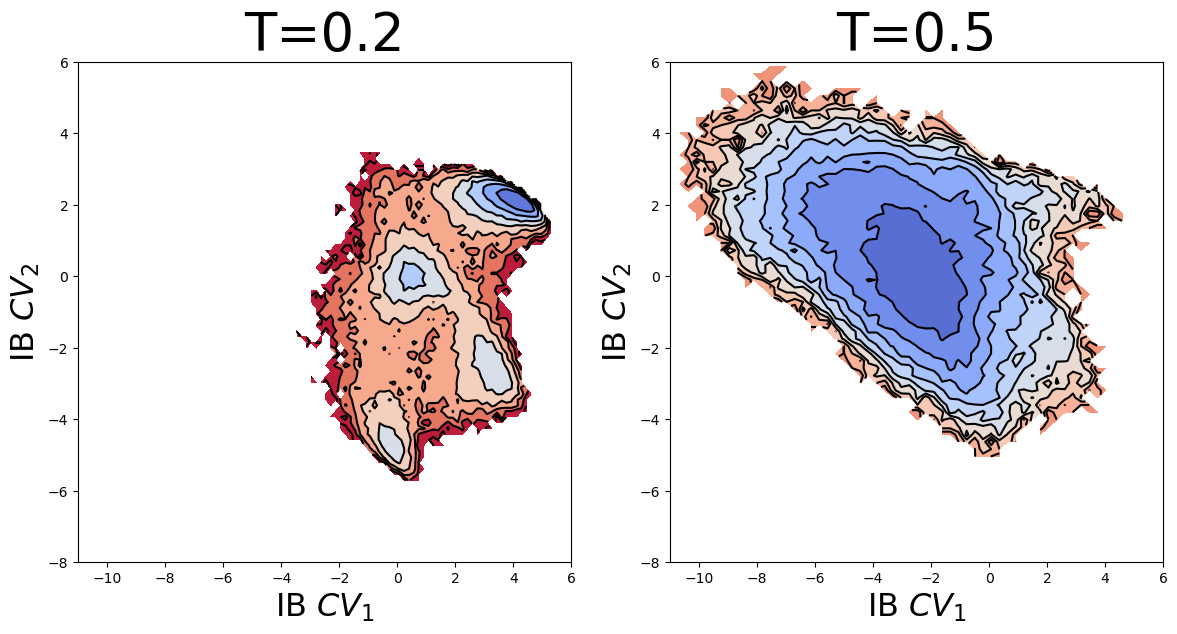

In [2]:
latf.eval()

normal_data2 = torch.from_numpy(traj_normal[0]).float().to(device); normal_data5 = torch.from_numpy(traj_normal[1]).float().to(device)
latent_mean2, _= latf.encode(normal_data2); flow_forward2, _ = latf.flow(latent_mean2);
latent_mean2 = latent_mean2.cpu().detach().numpy(); flow_forward2 = flow_forward2.cpu().detach().numpy(); 
latent_mean5, _= latf.encode(normal_data5); flow_forward5, _ = latf.flow(latent_mean5);
latent_mean5 = latent_mean5.cpu().detach().numpy(); flow_forward5 = flow_forward5.cpu().detach().numpy(); 

fig,ax = plt.subplots(1, 2, figsize=(14,6.5))  
RC_counts,RC_xbins,RC_ybins = np.histogram2d(latent_mean2[:,0],latent_mean2[:,1],bins=60)
RC_counts[RC_counts<2]=0
RC_G=-np.log(RC_counts)
RC_G=RC_G-np.nanmin(RC_G)

_x = np.zeros(len(RC_xbins)-1); _y = np.zeros(len(RC_ybins)-1)
for i in range(len(RC_xbins)-1):
    _x[i] = (RC_xbins[i] + RC_xbins[i+1]) / 2
    _y[i] = (RC_ybins[i] + RC_ybins[i+1]) / 2

ax[0].contourf(_x, _y,RC_G.transpose(),levels=10, cmap='coolwarm', vmin=0, vmax=6, alpha=0.9)
ax[0].contour(_x, _y, RC_G.transpose(),levels=10, colors='black', vmin=0, vmax=6, linewidth=0.5)
ax[0].set_title("T=0.2", fontsize=38)
ax[0].set_xlabel("IB $CV_{1}$",fontsize=23)
ax[0].set_ylabel("IB $CV_{2}$",fontsize=23)
ax[0].set_xlim(-11, 6)
ax[0].set_ylim(-8, 6)


RC_counts,RC_xbins,RC_ybins = np.histogram2d(latent_mean5[:,0],latent_mean5[:,1],bins=60)
RC_counts[RC_counts<2]=0
RC_G=-np.log(RC_counts)
RC_G=RC_G-np.nanmin(RC_G)

_x = np.zeros(len(RC_xbins)-1); _y = np.zeros(len(RC_ybins)-1)
for i in range(len(RC_xbins)-1):
    _x[i] = (RC_xbins[i] + RC_xbins[i+1]) / 2
    _y[i] = (RC_ybins[i] + RC_ybins[i+1]) / 2

ax[1].contourf(_x, _y,RC_G.transpose(),levels=10, cmap='coolwarm', vmin=0, vmax=6, alpha=0.9)
ax[1].contour(_x, _y, RC_G.transpose(),levels=10, colors='black', vmin=0, vmax=6, linewidth=0.5)
ax[1].set_title("T=0.5", fontsize=38)
ax[1].set_xlabel("IB $CV_{1}$",fontsize=23)
ax[1].set_ylabel("IB $CV_{2}$",fontsize=23)
ax[1].set_xlim(-11, 6)
ax[1].set_ylim(-8, 6)

## visualize flow-transformed encoded simulation data density in prior space

/var/folders/54/rr9b380j0ys7l0r5lqg904pr0000gp/T/ipykernel_3902/1095570670.py:4: RuntimeWarning: divide by zero encountered in log
  RC_G=-np.log(RC_counts)
/var/folders/54/rr9b380j0ys7l0r5lqg904pr0000gp/T/ipykernel_3902/1095570670.py:11: UserWarning: The following kwargs were not used by contour: 'linewidth'
  ax[0].contour(_x, _y, RC_G.transpose(),levels=10, colors='black', vmin=0.2, vmax=6, linewidth=0.5)
/var/folders/54/rr9b380j0ys7l0r5lqg904pr0000gp/T/ipykernel_3902/1095570670.py:21: RuntimeWarning: divide by zero encountered in log
  RC_G=-np.log(RC_counts)
/var/folders/54/rr9b380j0ys7l0r5lqg904pr0000gp/T/ipykernel_3902/1095570670.py:28: UserWarning: The following kwargs were not used by contour: 'linewidth'
  ax[1].contour(_x, _y, RC_G.transpose(),levels=10, colors='black', vmin=0.2, vmax=6, linewidth=0.5)


(-12.0, 12.0)

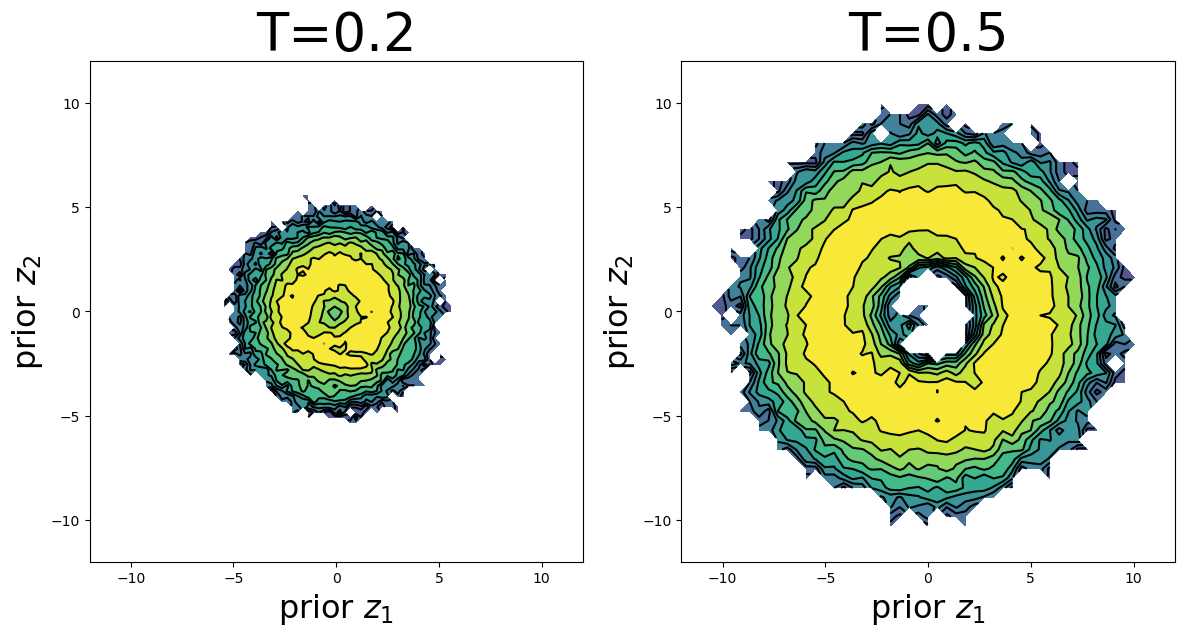

In [3]:
fig,ax = plt.subplots(1, 2, figsize=(14,6.5))  
RC_counts,RC_xbins,RC_ybins = np.histogram2d(flow_forward2[:,0],flow_forward2[:,1],bins=50)
RC_counts[RC_counts<2]=0
RC_G=-np.log(RC_counts)
RC_G=RC_G-np.nanmin(RC_G)
_x = np.zeros(len(RC_xbins)-1); _y = np.zeros(len(RC_ybins)-1)
for i in range(len(RC_xbins)-1):
    _x[i] = (RC_xbins[i] + RC_xbins[i+1]) / 2
    _y[i] = (RC_ybins[i] + RC_ybins[i+1]) / 2
ax[0].contourf(_x, _y,RC_G.transpose(),levels=10, cmap='viridis_r', vmin=0.2, vmax=6, alpha=0.9)
ax[0].contour(_x, _y, RC_G.transpose(),levels=10, colors='black', vmin=0.2, vmax=6, linewidth=0.5)
ax[0].set_title("T=0.2", fontsize=38)
ax[0].set_xlabel("prior $z_{1}$",fontsize=23)
ax[0].set_ylabel("prior $z_{2}$",fontsize=23)
ax[0].set_xlim(-12, 12)
ax[0].set_ylim(-12, 12)


RC_counts,RC_xbins,RC_ybins = np.histogram2d(flow_forward5[:,0],flow_forward5[:,1],bins=50)
RC_counts[RC_counts<2]=0
RC_G=-np.log(RC_counts)
RC_G=RC_G-np.nanmin(RC_G)
_x = np.zeros(len(RC_xbins)-1); _y = np.zeros(len(RC_ybins)-1)
for i in range(len(RC_xbins)-1):
    _x[i] = (RC_xbins[i] + RC_xbins[i+1]) / 2
    _y[i] = (RC_ybins[i] + RC_ybins[i+1]) / 2
ax[1].contourf(_x, _y,RC_G.transpose(),levels=10, cmap='viridis_r', vmin=0.2, vmax=6, alpha=0.9)
ax[1].contour(_x, _y, RC_G.transpose(),levels=10, colors='black', vmin=0.2, vmax=6, linewidth=0.5)
ax[1].set_title("T=0.5", fontsize=38)
ax[1].set_xlabel("prior $z_{1}$",fontsize=23)
ax[1].set_ylabel("prior $z_{2}$",fontsize=23)
ax[1].set_xlim(-12, 12)
ax[1].set_ylim(-12, 12)

## visualize LaTF generated latent IB distribution

/var/folders/54/rr9b380j0ys7l0r5lqg904pr0000gp/T/ipykernel_3902/2227712722.py:14: RuntimeWarning: divide by zero encountered in log
  RC_G=-np.log(RC_counts)
/var/folders/54/rr9b380j0ys7l0r5lqg904pr0000gp/T/ipykernel_3902/2227712722.py:21: UserWarning: The following kwargs were not used by contour: 'linewidth'
  ax[0].contour(_x, _y, RC_G.transpose(),levels=10, colors='black', vmin=0, vmax=6, linewidth=0.5)
/var/folders/54/rr9b380j0ys7l0r5lqg904pr0000gp/T/ipykernel_3902/2227712722.py:31: RuntimeWarning: divide by zero encountered in log
  RC_G=-np.log(RC_counts)
/var/folders/54/rr9b380j0ys7l0r5lqg904pr0000gp/T/ipykernel_3902/2227712722.py:38: UserWarning: The following kwargs were not used by contour: 'linewidth'
  ax[1].contour(_x, _y, RC_G.transpose(),levels=10, colors='black', vmin=0, vmax=6, linewidth=0.5)


(-8.0, 6.0)

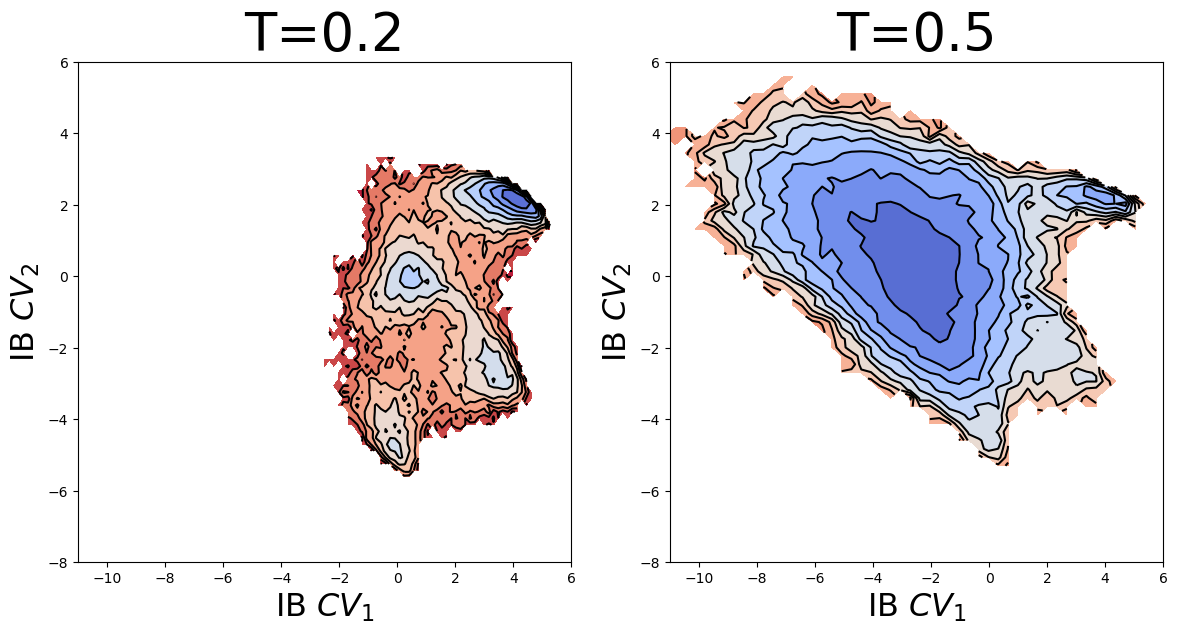

In [4]:
with torch.no_grad():
    samples2 = generate_sample_from_flow(tau=2, dz=2, temp=2/2, model=latf, num_samples=int(6000))
    samples2 = samples2[~np.isnan(samples2[:, 0])]
    samples2 = samples2[~np.isnan(samples2[:, 1])]
    samples2 = samples2[np.sum(np.abs(samples2), axis=1) < 20]
    samples7 = generate_sample_from_flow(tau=2, dz=2, temp=5/2, model=latf, num_samples=int(6000))
    samples7 = samples7[~np.isnan(samples7[:, 0])]
    samples7 = samples7[~np.isnan(samples7[:, 1])]
    samples7 = samples7[np.sum(np.abs(samples7), axis=1) < 20]

fig,ax = plt.subplots(1, 2, figsize=(14,6.5))  
RC_counts,RC_xbins,RC_ybins = np.histogram2d(samples2[:,0],samples2[:,1],bins=60)
RC_counts[RC_counts<5]=0
RC_G=-np.log(RC_counts)
RC_G=RC_G-np.nanmin(RC_G)
_x = np.zeros(len(RC_xbins)-1); _y = np.zeros(len(RC_ybins)-1)
for i in range(len(RC_xbins)-1):
    _x[i] = (RC_xbins[i] + RC_xbins[i+1]) / 2
    _y[i] = (RC_ybins[i] + RC_ybins[i+1]) / 2
ax[0].contourf(_x, _y,RC_G.transpose(),levels=10, cmap='coolwarm', vmin=0, vmax=6, alpha=0.9)
ax[0].contour(_x, _y, RC_G.transpose(),levels=10, colors='black', vmin=0, vmax=6, linewidth=0.5)
ax[0].set_title("T=0.2", fontsize=38)
ax[0].set_xlabel("IB $CV_{1}$",fontsize=23)
ax[0].set_ylabel("IB $CV_{2}$",fontsize=23)
ax[0].set_xlim(-11, 6)
ax[0].set_ylim(-8, 6)


RC_counts,RC_xbins,RC_ybins = np.histogram2d(samples7[:,0],samples7[:,1],bins=60)
RC_counts[RC_counts<5]=0
RC_G=-np.log(RC_counts)
RC_G=RC_G-np.nanmin(RC_G)
_x = np.zeros(len(RC_xbins)-1); _y = np.zeros(len(RC_ybins)-1)
for i in range(len(RC_xbins)-1):
    _x[i] = (RC_xbins[i] + RC_xbins[i+1]) / 2
    _y[i] = (RC_ybins[i] + RC_ybins[i+1]) / 2
ax[1].contourf(_x, _y,RC_G.transpose(),levels=10, cmap='coolwarm', vmin=0, vmax=6, alpha=0.9)
ax[1].contour(_x, _y, RC_G.transpose(),levels=10, colors='black', vmin=0, vmax=6, linewidth=0.5)
ax[1].set_title("T=0.5", fontsize=38)
ax[1].set_xlabel("IB $CV_{1}$",fontsize=23)
ax[1].set_ylabel("IB $CV_{2}$",fontsize=23)
ax[1].set_xlim(-11, 6)
ax[1].set_ylim(-8, 6)

## predict temperature-dependent FES in latent IB space

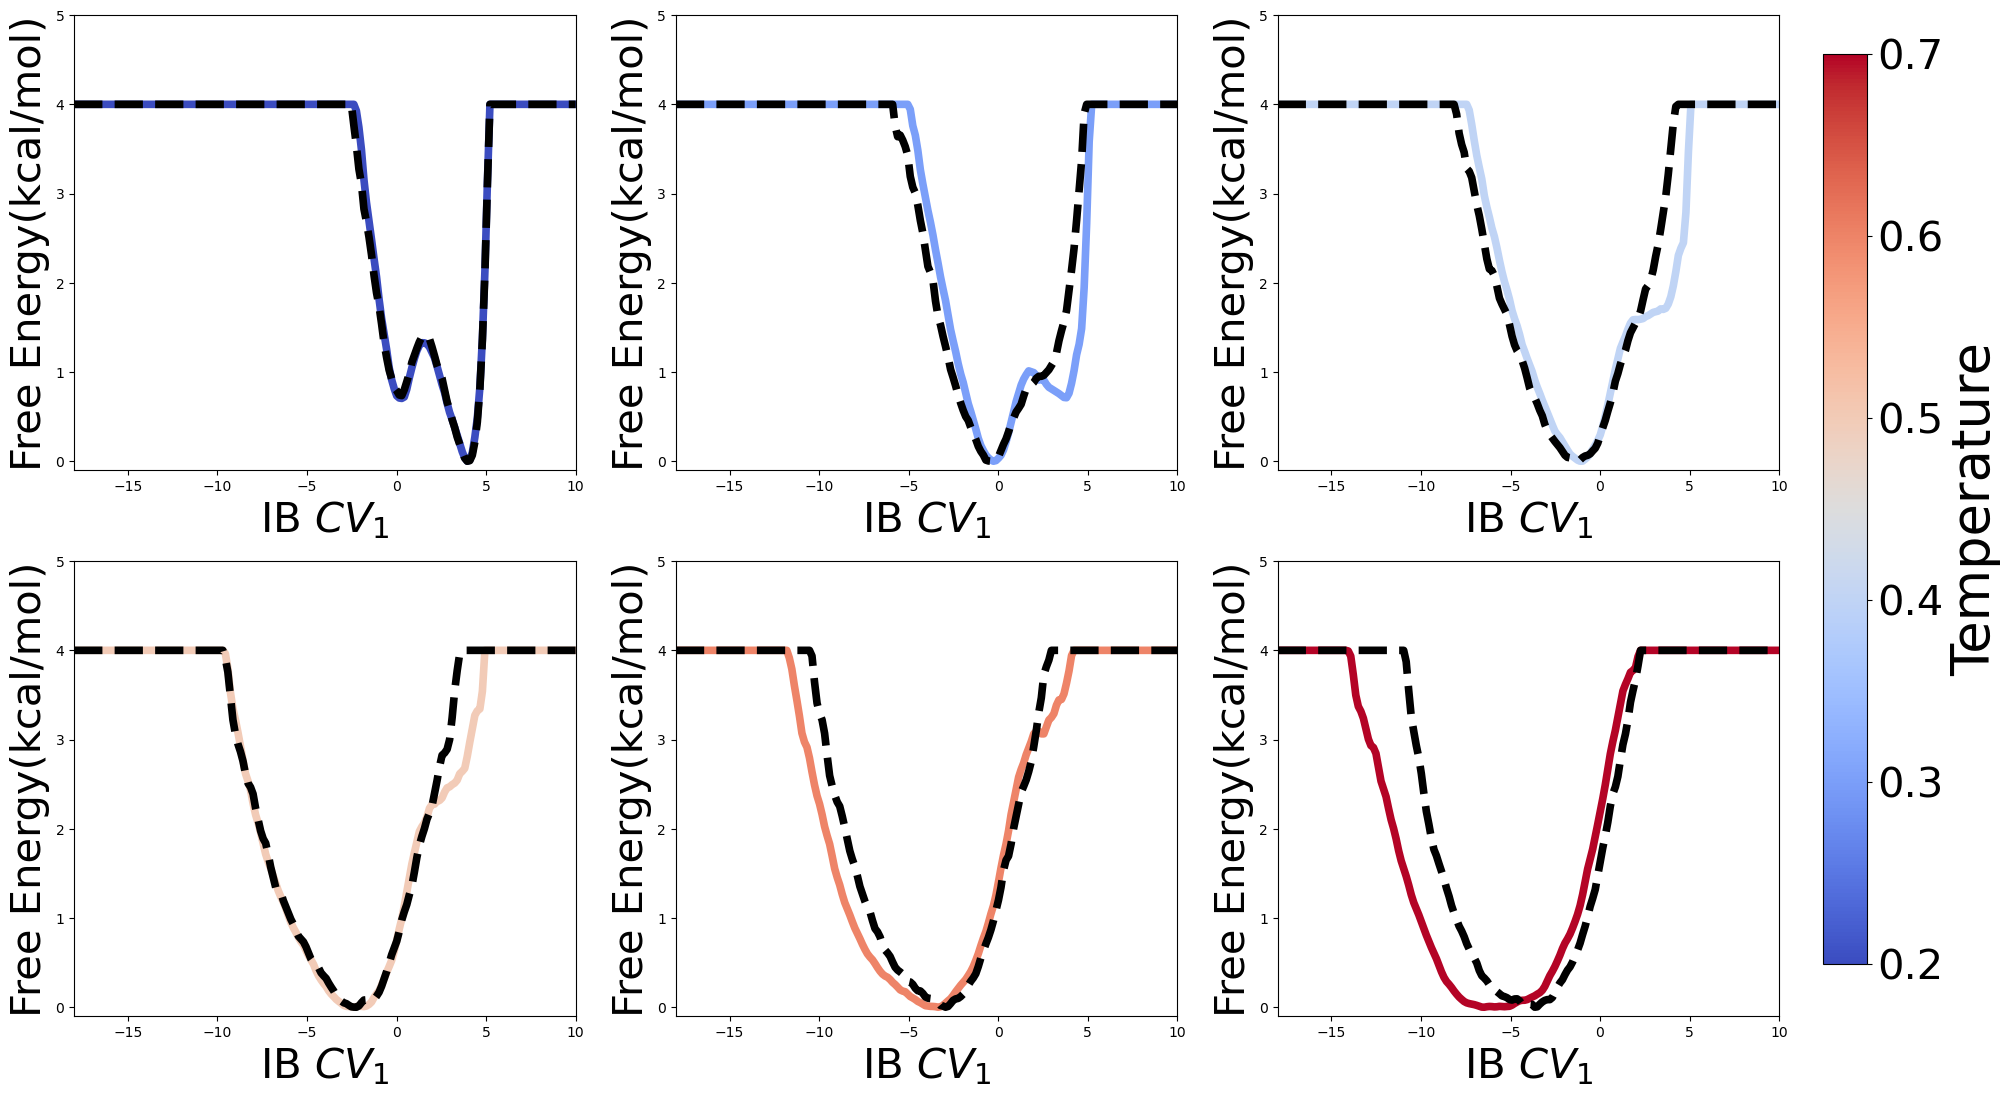

In [5]:
import matplotlib
import matplotlib.colors as mcolors

md_data = np.load('../dataset/LJ7_all_temperatures_sparse_trajs.npy', allow_pickle=True).item()
md_data = [(v- traj_mean[None, :])/traj_std[None, :] for v in md_data.values()]
md_ref = []
for i in range(len(md_data)):
    _p, _ = latf.encode(torch.from_numpy(md_data[i]).float())
    md_ref.append(_p.detach().numpy())

generate_samples = {}
with torch.no_grad():
    for temp in [2, 3, 4, 5, 6, 7]:
        _s = generate_sample_from_flow(tau=2, dz=2, temp=temp/2, model=latf, num_samples=int(6000))
        _s = _s[~np.isnan(_s[:, 0])]
        _s = _s[~np.isnan(_s[:, 1])]
        _s = _s[np.sum(np.abs(_s), axis=1) < 20]
        generate_samples[temp] = _s

cmap = matplotlib.cm.coolwarm
norm = mcolors.Normalize(vmin=2, vmax=7)
values = np.linspace(2, 7, 6)
colors = cmap(norm(values))

fig,ax = plt.subplots(2, 3, figsize=(22,13))  
for i, temp in enumerate([2, 3, 4, 5, 6, 7]):
    sample_kde = gaussian_kde(generate_samples[temp][:, 0], bw_method=0.05) 
    sample_grid = np.linspace(-18, 10, 200)
    sample_x = sample_kde(sample_grid)
    sample_fe = -np.log(sample_x + 1e-7)
    sample_fe=sample_fe-np.min(sample_fe);
    sample_fe[sample_fe > 4.0] = 4.0

    md_kde = gaussian_kde(md_ref[i][:, 0], bw_method=0.05) 
    md_grid = np.linspace(-18, 10, 200)
    md_x = md_kde(md_grid)
    md_fe = -np.log(md_x + 1e-7)
    md_fe=md_fe-np.min(md_fe);
    md_fe[md_fe > 4.0] = 4.0

    ax[i//3, i%3].plot(sample_grid, sample_fe, linewidth=5.5, color=colors[i])
    ax[i//3, i%3].plot(md_grid, md_fe, linewidth=5.5, color='black', linestyle='--')
    ax[i//3, i%3].set_xlabel("IB $CV_{1}$",fontsize=30)
    ax[i//3, i%3].set_ylabel('Free Energy(kcal/mol)', fontsize=30)
    ax[i//3, i%3].set_xlim(-18,10)
    ax[i//3, i%3].set_ylim(-0.1, 5.0)

l = 0.92; b = 0.15; w = 0.02; h = 0.7
rect = [l, b, w, h]
cbar_ax = fig.add_axes(rect)
cb = fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0.2, vmax=0.7), cmap=plt.cm.coolwarm), cax=cbar_ax)
cb.ax.tick_params(labelsize=30)
cb.set_label('Temperature',fontsize=38)

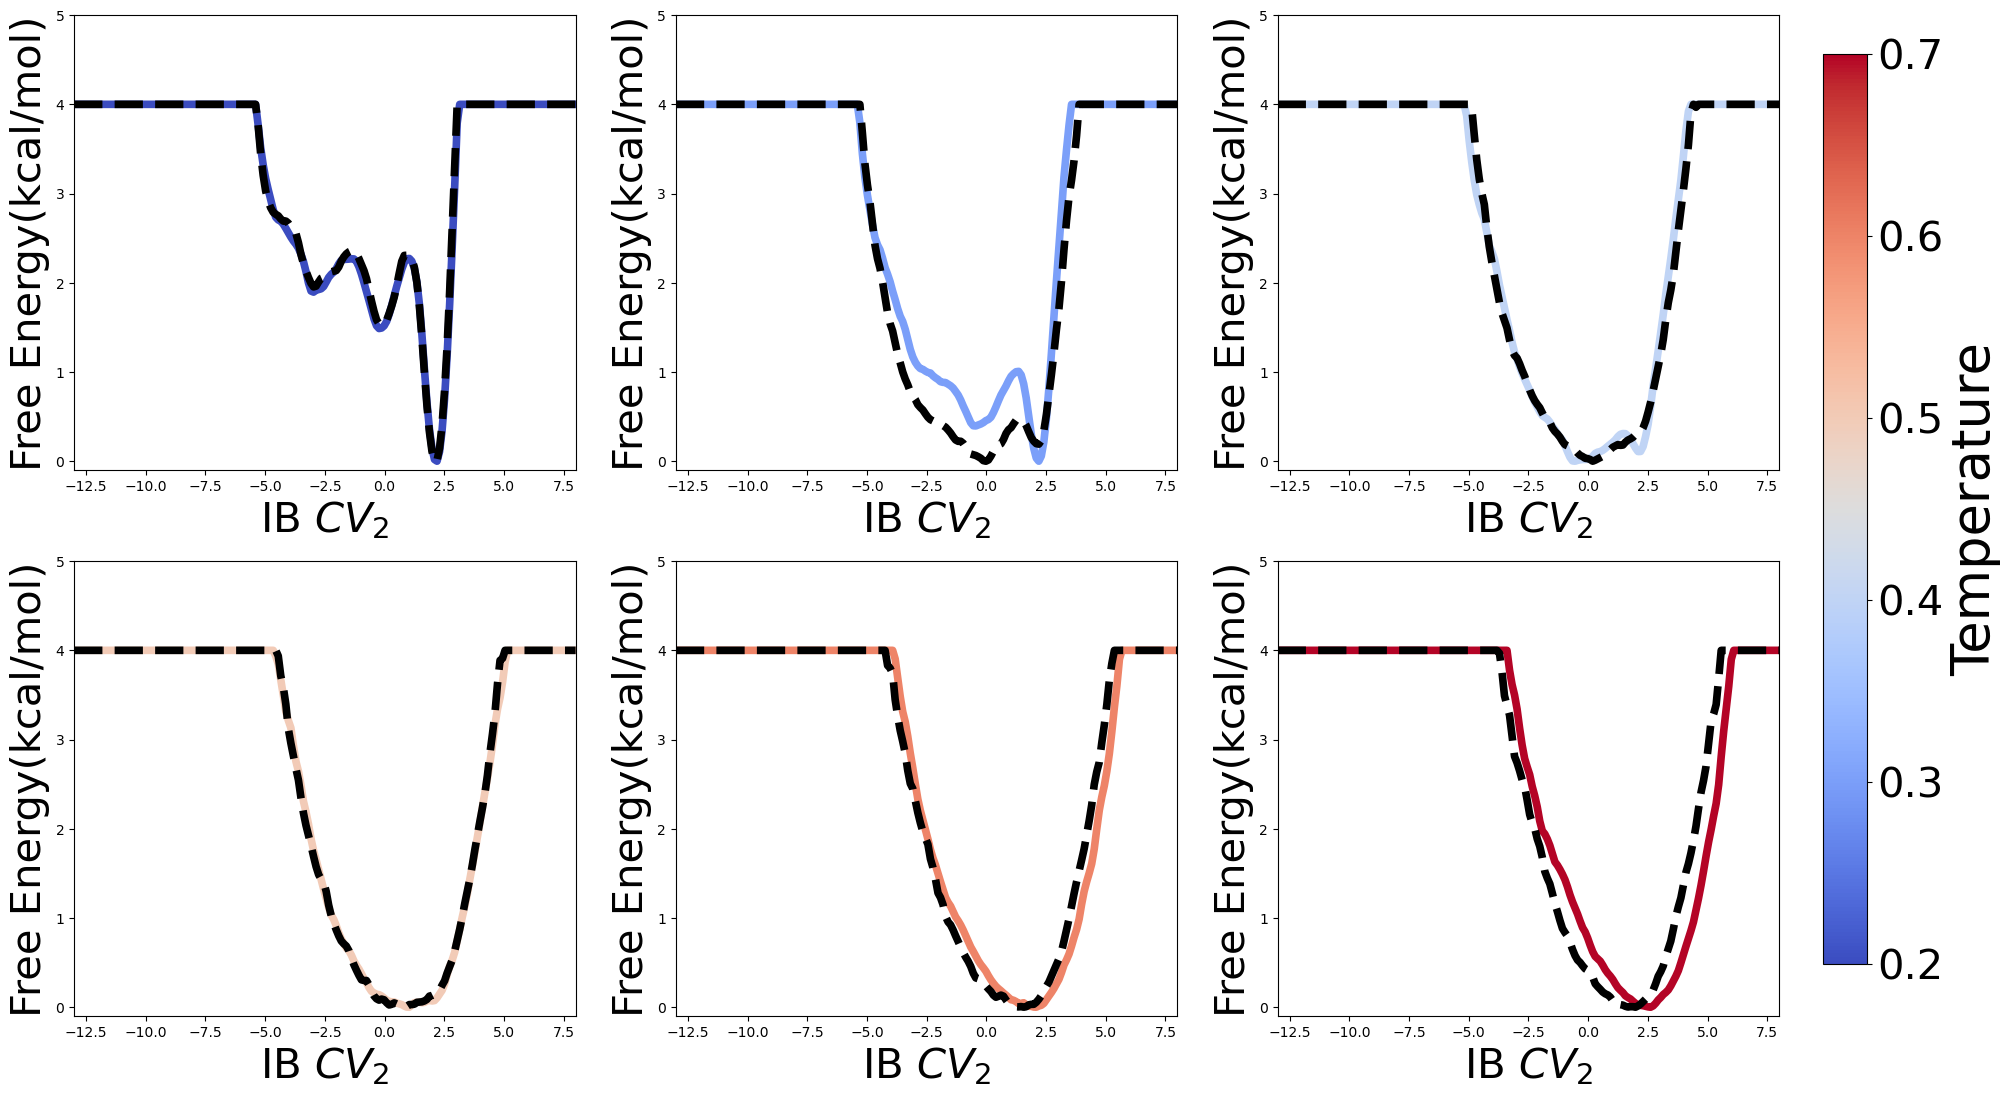

In [6]:
fig,ax = plt.subplots(2, 3, figsize=(22,13))  
for i, temp in enumerate([2, 3, 4, 5, 6, 7]):
    sample_kde = gaussian_kde(generate_samples[temp][:, 1], bw_method=0.05) 
    sample_grid = np.linspace(-13, 8, 200)
    sample_x = sample_kde(sample_grid)
    sample_fe = -np.log(sample_x + 1e-7)
    sample_fe=sample_fe-np.min(sample_fe);
    sample_fe[sample_fe > 4.0] = 4.0

    md_kde = gaussian_kde(md_ref[i][:, 1], bw_method=0.05) 
    md_grid = np.linspace(-13, 8, 200)
    md_x = md_kde(md_grid)
    md_fe = -np.log(md_x + 1e-7)
    md_fe=md_fe-np.min(md_fe);
    md_fe[md_fe > 4.0] = 4.0

    ax[i//3, i%3].plot(sample_grid, sample_fe, linewidth=5.5, color=colors[i])
    ax[i//3, i%3].plot(md_grid, md_fe, linewidth=5.5, color='black', linestyle='--')
    ax[i//3, i%3].set_xlabel("IB $CV_{2}$",fontsize=30)
    ax[i//3, i%3].set_ylabel('Free Energy(kcal/mol)', fontsize=30)
    ax[i//3, i%3].set_xlim(-13, 8)
    ax[i//3, i%3].set_ylim(-0.1, 5.0)

l = 0.92; b = 0.15; w = 0.02; h = 0.7
rect = [l, b, w, h]
cbar_ax = fig.add_axes(rect)
cb = fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0.2, vmax=0.7), cmap=plt.cm.coolwarm), cax=cbar_ax)
cb.ax.tick_params(labelsize=30)
cb.set_label('Temperature',fontsize=38)